In [5]:
import os
import numpy as np
import random
import csv
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from dataset import dataset
from knn import knn
from enn import enn
from kmeans import kmeans

In [6]:
def process_all(user: str, shuffle_split: bool):
    abalone_data = dataset('/home/'+user+'/CSCI_447/Project_2/Datasets/abalone.data', False)
    cancer_data = dataset('/home/'+user+'/CSCI_447/Project_2/Datasets/breast-cancer-wisconsin.data', False)
    fire_data = dataset('/home/'+user+'/CSCI_447/Project_2/Datasets/forestfires.data', False)
    glass_data = dataset('/home/'+user+'/CSCI_447/Project_2/Datasets/glass.data', False)
    machine_data = dataset('/home/'+user+'/CSCI_447/Project_2/Datasets/machine.data', False)
    soybean_data = dataset('/home/'+user+'/CSCI_447/Project_2/Datasets/soybean-small.data', False)

    abalone_data.continuize()
    abalone_data.normalize()
    abalone_data.shuffle()
    abalone_data.sort('regression')
    abalone_data.split()
    abalone_data.fold()

    cancer_data.remove_attribute()
    cancer_data.impute()
    cancer_data.shuffle()
    cancer_data.sort('classification')
    cancer_data.split()
    cancer_data.fold()

    fire_data.continuize()
    fire_data.normalize()
    fire_data.shuffle()
    fire_data.sort('regression')
    fire_data.split()
    fire_data.fold()

    glass_data.continuize()
    glass_data.remove_attribute()
    glass_data.shuffle()
    glass_data.sort('classification')
    glass_data.split()
    glass_data.fold()

    machine_data.continuize()
    machine_data.normalize()
    machine_data.shuffle()
    machine_data.sort('regression')
    machine_data.split()
    machine_data.fold()

    soybean_data.continuize()
    soybean_data.shuffle()
    soybean_data.sort('classification')
    soybean_data.split()
    soybean_data.fold()

    if (shuffle_split == True) :
        abalone_data.shuffle_splits()
        cancer_data.shuffle_splits()
        fire_data.shuffle_splits()
        glass_data.shuffle_splits()
        machine_data.shuffle_splits()
        soybean_data.shuffle_splits()

    abalone_data.save('abalone')
    cancer_data.save('cancer')
    fire_data.save('fire')
    glass_data.save('glass')
    machine_data.save('machine')
    soybean_data.save('soybean')

    return abalone_data, cancer_data, fire_data, glass_data, machine_data, soybean_data

In [7]:
abalone_data, cancer_data, fire_data, glass_data, machine_data, soybean_data = process_all('carlthedog3', True)

In [ ]:
cancer_kmeans = kmeans(cancer_data,'classification')
glass_kmeans = kmeans(glass_data,'classification')
soybean_kmeans = kmeans(soybean_data,'classification')
abalone_kmeans = kmeans(abalone_data, 'regression')
fire_kmeans = kmeans(fire_data, 'regression')
machine_kmeans = kmeans(machine_data, 'regression')

cancer_kmeans.tune()
glass_kmeans.tune(k_c_increment=3)
soybean_kmeans.tune()
abalone_kmeans.tune()
fire_kmeans.tune()
machine_kmeans.tune()

cancer_kmeans_results = cancer_kmeans.classify()
glass_kmeans_results = glass_kmeans.classify()
soybean_kmeans_results = soybean_kmeans.classify()
abalone_kmeans_results = abalone_kmeans.regress()
fire_kmeans_results = fire_kmeans.regress()
machine_kmeans_results = machine_kmeans.regress()

# Used to see if kmeans cancer ran without issues
print(f"Cancer K-Means Loss:\n{cancer_kmeans_results}")
#print(f"Glass K-Means Loss:\n{glass_kmeans_results}")
#print(f"Soybean K-Means Loss:\n{soybean_kmeans_results}")
#print(f"Abalone K-Means Loss:\n{abalone_kmeans_results}")
#print(f"Fire K-Means Loss:\n{fire_kmeans_results}")
#print(f"Machine K-Means Loss:\n{machine_kmeans_results}")

Tuning K_c...:   0%|          | 0/15 [00:00<?, ?it/s]

Tuning K_n...: 100%|██████████| 15/15 [00:02<00:00,  5.27it/s]


Tuned k_c: 1
Tuned k_n: 4


Tuning K_n...: 100%|██████████| 15/15 [00:02<00:00,  6.80it/s]


Tuned k_c: 33
Tuned k_n: 1


Tuning K_n...: 100%|██████████| 15/15 [00:00<00:00, 32.49it/s]


Tuned k_c: 12
Tuned k_n: 1


Tuning K_c...:  87%|████████▋ | 13/15 [00:08<00:01,  1.19it/s]

In [37]:
'''
Test code to see if all methods are outputting 10x2 array
'''
'''
cancer_kmeans = kmeans(cancer_data,'classification')
fire_kmeans = kmeans(fire_data, 'regression')
cancer_knn = knn(cancer_data, 'classification')
fire_knn = knn(fire_data, 'regression')
cancer_enn = enn(cancer_data, 'classification', k_n=cancer_knn.k_n, sigma=cancer_knn.sigma)
fire_enn = enn(fire_data, 'regression', k_n=fire_knn.k_n, sigma=fire_knn.sigma)

cancer_kmeans.tune(5)
fire_kmeans.tune(5)
cancer_knn.tune(5)
fire_knn.tune(5)
cancer_enn.tune(5)
fire_enn.tune(5)

cancer_kmeans_results = cancer_kmeans.classify()
fire_kmeans_results = fire_kmeans.regress()
cancer_knn_results = cancer_knn.classify()
fire_knn_results = fire_knn.regress()
cancer_enn_results = cancer_enn.classify()
fire_enn_results = fire_enn.regress()

print(f"Cancer KNN Loss:\n{cancer_knn_results}")
print(f"Fire KNN Loss:\n{fire_knn_results}")
print(f"Cancer ENN Loss:\n{cancer_enn_results}")
print(f"Fire ENN Loss:\n{fire_enn_results}")
print(f"Cancer K-Means Loss:\n{cancer_kmeans_results}")
print(f"Fire K-Means Loss:\n{fire_kmeans_results}")
'''

'\ncancer_kmeans = kmeans(cancer_data,\'classification\')\nfire_kmeans = kmeans(fire_data, \'regression\')\ncancer_knn = knn(cancer_data, \'classification\')\nfire_knn = knn(fire_data, \'regression\')\ncancer_enn = enn(cancer_data, \'classification\', k_n=cancer_knn.k_n, sigma=cancer_knn.sigma)\nfire_enn = enn(fire_data, \'regression\', k_n=fire_knn.k_n, sigma=fire_knn.sigma)\n\ncancer_kmeans.tune(5)\nfire_kmeans.tune(5)\ncancer_knn.tune(5)\nfire_knn.tune(5)\ncancer_enn.tune(5)\nfire_enn.tune(5)\n\ncancer_kmeans_results = cancer_kmeans.classify()\nfire_kmeans_results = fire_kmeans.regress()\ncancer_knn_results = cancer_knn.classify()\nfire_knn_results = fire_knn.regress()\ncancer_enn_results = cancer_enn.classify()\nfire_enn_results = fire_enn.regress()\n\nprint(f"Cancer KNN Loss:\n{cancer_knn_results}")\nprint(f"Fire KNN Loss:\n{fire_knn_results}")\nprint(f"Cancer ENN Loss:\n{cancer_enn_results}")\nprint(f"Fire ENN Loss:\n{fire_enn_results}")\nprint(f"Cancer K-Means Loss:\n{cancer_kme

In [ ]:
cancer_knn = knn(cancer_data, 'classification')
glass_knn = knn(glass_data, "classification")
soybean_knn = knn(soybean_data, "classification")
abalone_knn = knn(abalone_data, 'regression')
fire_knn = knn(fire_data, 'regression')
machine_knn = knn(machine_data, 'regression')

cancer_knn.tune(15)
glass_knn.tune(15)
soybean_knn.tune(10)
abalone_knn.tune(5)
fire_knn.tune(15)
machine_knn.tune(10)

In [ ]:
cancer_enn = enn(cancer_data, 'classification', k_n=cancer_knn.k_n, sigma=cancer_knn.sigma)
glass_enn = enn(glass_data, "classification", k_n=glass_knn.k_n, sigma=glass_knn.sigma)
soybean_enn = enn(soybean_data, "classification", k_n=soybean_knn.k_n, sigma=soybean_knn.sigma)
abalone_enn = enn(abalone_data, 'regression', k_n=abalone_knn.k_n, sigma=abalone_knn.sigma)
fire_enn = enn(fire_data, 'regression', k_n=fire_knn.k_n, sigma=fire_knn.sigma)
machine_enn = enn(machine_data, 'regression', k_n=machine_knn.k_n, sigma=machine_knn.sigma)

cancer_enn.tune(15)
glass_enn.tune(10)
soybean_enn.tune(10)
abalone_enn.tune(5)
fire_enn.tune(10)
machine_enn.tune(25)

In [ ]:
cancer_knn_results = cancer_knn.classify()
glass_knn_results = glass_knn.classify()
soybean_knn_results = soybean_knn.classify()
abalone_knn_results = abalone_knn.regress()
fire_knn_results = fire_knn.regress()
machine_knn_results = machine_knn.regress()

cancer_enn_results = cancer_enn.classify()
glass_enn_results = glass_enn.classify()
soybean_enn_results = soybean_enn.classify()
abalone_enn_results = abalone_enn.regress()
fire_enn_results = fire_enn.regress()
machine_enn_results = machine_enn.regress()

In [ ]:

print(f"Cancer KNN Loss:\n{cancer_knn_results}")
print(f"Glass KNN Loss:\n{glass_knn_results}")
print(f"Soybean KNN Loss:\n{soybean_knn_results}")
print(f"Abalone KNN Loss:\n{abalone_knn_results}")
print(f"Fire KNN Loss:\n{fire_knn_results}")
print(f"Machine KNN Loss:\n{machine_knn_results}")

print(f"Cancer ENN Loss:\n{cancer_enn_results}")
print(f"Glass ENN Loss:\n{glass_enn_results}")
print(f"Soybean ENN Loss:\n{soybean_enn_results}")
print(f"Abalone ENN Loss:\n{abalone_enn_results}")
print(f"Fire ENN Loss:\n{fire_enn_results}")
print(f"Machine ENN Loss:\n{machine_enn_results}")

print(f"Cancer K-Means Loss:\n{cancer_kmeans_results}")
print(f"Glass K-Means Loss:\n{glass_kmeans_results}")
print(f"Soybean K-Means Loss:\n{soybean_kmeans_results}")
print(f"Abalone K-Means Loss:\n{abalone_kmeans_results}")
print(f"Fire K-Means Loss:\n{fire_kmeans_results}")
print(f"Machine K-Means Loss:\n{machine_kmeans_results}")

In [2]:
def save_arrays_to_csv(arrays, filename):
    """
    Save 18 numpy arrays (each 10x2) to a single CSV file.
    
    Parameters:
    arrays (list of np.ndarray): List of 18 numpy arrays to be saved.
    filename (str): Name of the CSV file to save the arrays.
    """
    if len(arrays) != 18:
        raise ValueError("The input must contain 18 numpy arrays.")
    
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Write metadata to identify where each array starts
        for idx, array in enumerate(arrays):
            writer.writerow([f"Array {idx+1}"])
            writer.writerows(array)
            writer.writerow([])  # Empty line for separation between arrays

def load_arrays_from_csv(filename):
    """
    Load 18 numpy arrays (each 10x2) from a CSV file.
    
    Parameters:
    filename (str): Name of the CSV file to load the arrays from.
    
    Returns:
    list of np.ndarray: List of 18 numpy arrays extracted from the CSV file.
    """
    arrays = []
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        current_array = []
        
        for row in reader:
            # Check for metadata line or empty line
            if len(row) == 0:
                continue
            elif "Array" in row[0]:
                if current_array:
                    arrays.append(np.array(current_array, dtype=float))
                    current_array = []
            else:
                current_array.append([float(val) for val in row])
        
        # Add the last array if present
        if current_array:
            arrays.append(np.array(current_array, dtype=float))
    
    if len(arrays) != 18:
        raise ValueError("Expected to extract 18 arrays, but found a different number.")
    
    return arrays
classification_arrays = [cancer_knn_results,cancer_enn_results,cancer_kmeans_results,
                         glass_knn_results,glass_enn_results,glass_kmeans_results,
                         soybean_knn_results,soybean_enn_results,soybean_kmeans_results]
regression_arrays = [abalone_knn_results,abalone_enn_results,abalone_kmeans_results,
                     fire_knn_results,fire_enn_results,fire_kmeans_results,
                     machine_knn_results,machine_enn_results,machine_kmeans_results]
arrays_to_save = []
arrays_to_save.extend(classification_arrays)
arrays_to_save.extend(regression_arrays)
save_arrays_to_csv(arrays_to_save, 'normalized_data.csv')


NameError: name 'cancer_knn_results' is not defined

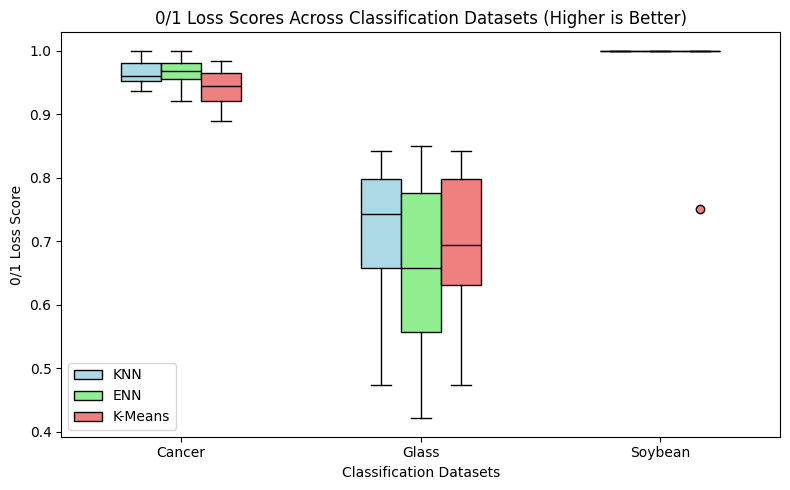

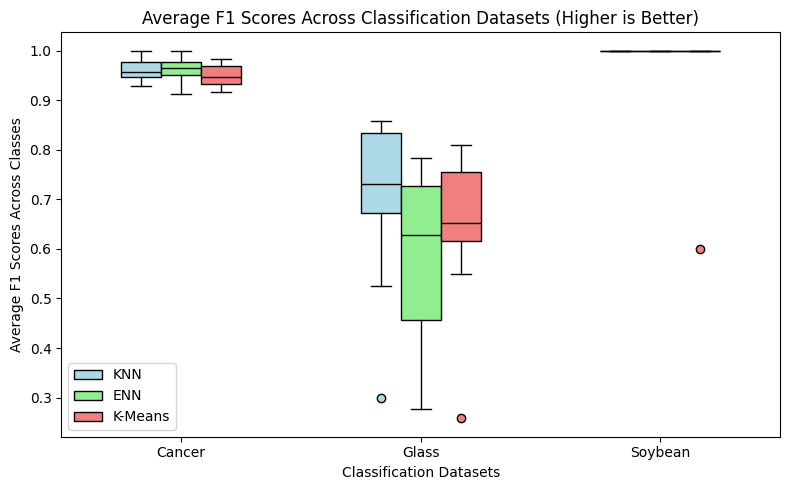

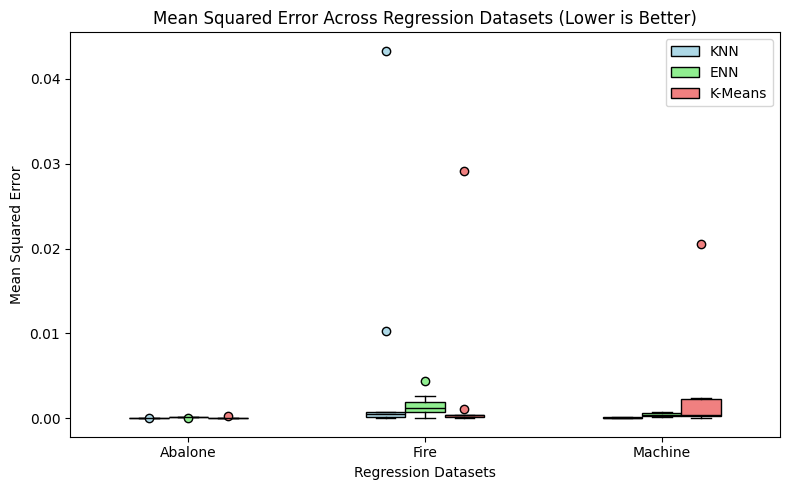

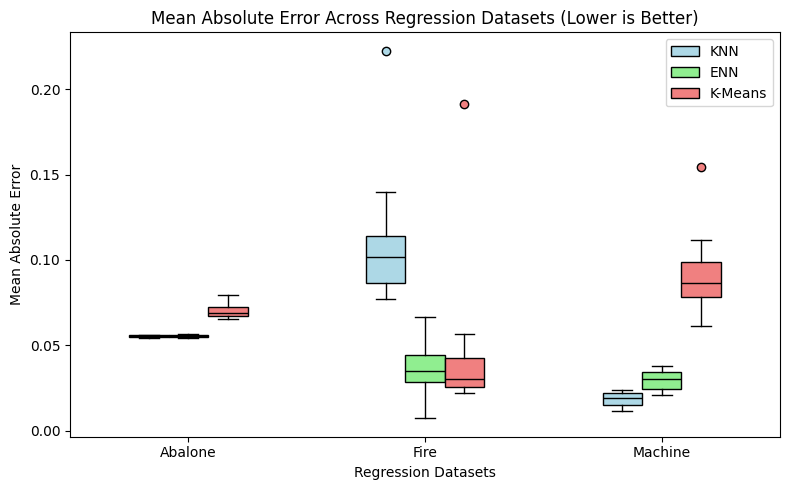

In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
def make_plots_2(arrays: list, classification_names: list, regression_names: list, figure_size: tuple, rotation_val: int, save_path: str):
    '''
    This function creates boxplots for the 2 performance metrics for both classification and regression.
    This function will output 4 plots, 0/1 loss for classification, F1 score for classification,
    MSE for regression, and MAE for regression.
    '''
    if len(arrays) != 18:
        raise ValueError("Expected a list of 18 numpy arrays.")

    # Split the arrays into classification and regression
    classification_arrays = arrays[:9]
    regression_arrays = arrays[9:]
    # Extract metrics for classification
    loss_data = [classification_arrays[i][:, 0] for i in range(len(classification_arrays))]
    f1_data = [classification_arrays[i][:, 1] for i in range(len(classification_arrays))]
    # Extract metrics for regression
    mse_data = [regression_arrays[i][:, 0] for i in range(len(regression_arrays))]
    mae_data = [regression_arrays[i][:, 1] for i in range(len(regression_arrays))]
    # Positions for boxplots - 3 models per dataset
    num_models = 3
    def calculate_positions(num_datasets, num_models, spacing, width):
        positions = []
        for i in range(num_datasets):
            base_position = i * spacing * num_models
            positions.extend([base_position, base_position + width, base_position + 2 * width])
        return positions
    # Consider making these input parameters
    width = 0.25
    spacing = .5
    positions_classification = calculate_positions(len(classification_names), num_models, spacing, width)
    positions_regression = calculate_positions(len(regression_names), num_models, spacing, width)
    # Choose colors for each model
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    model_names = ['KNN', 'ENN', 'K-Means']

    # Plotting 0/1 Loss
    plt.figure(figsize=figure_size)
    for i in range(num_models):
        plt.boxplot([loss_data[j] for j in range(i, len(loss_data), num_models)],
                    positions=[positions_classification[j] for j in range(i, len(positions_classification), num_models)],
                    widths=width, patch_artist=True, boxprops=dict(facecolor=colors[i]),
                    medianprops=dict(color='black'), whiskerprops=dict(color='black'),
                    capprops=dict(color='black'), flierprops=dict(markerfacecolor=colors[i], marker='o'),
                    label=model_names[i])
    plt.xticks([i * spacing * num_models + width for i in range(len(classification_names))], classification_names, rotation=rotation_val)
    plt.xlabel('Classification Datasets')
    plt.ylabel('0/1 Loss Score')
    plt.title('0/1 Loss Scores Across Classification Datasets (Higher is Better)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{save_path}01_loss.png")
    plt.show()

    # Plotting F1 Score
    plt.figure(figsize=figure_size)
    for i in range(num_models):
        plt.boxplot([f1_data[j] for j in range(i, len(f1_data), num_models)],
                    positions=[positions_classification[j] for j in range(i, len(positions_classification), num_models)],
                    widths=width, patch_artist=True, boxprops=dict(facecolor=colors[i]),
                    medianprops=dict(color='black'), whiskerprops=dict(color='black'),
                    capprops=dict(color='black'), flierprops=dict(markerfacecolor=colors[i], marker='o'),
                    label=model_names[i])
    plt.xticks([i * spacing * num_models + width for i in range(len(classification_names))], classification_names, rotation=rotation_val)
    plt.xlabel('Classification Datasets')
    plt.ylabel('Average F1 Scores Across Classes')
    plt.title('Average F1 Scores Across Classification Datasets (Higher is Better)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{save_path}f1_score.png")
    plt.show()

    # Plotting MSE
    plt.figure(figsize=figure_size)
    for i in range(num_models):
        plt.boxplot([mse_data[j] for j in range(i, len(mse_data), num_models)],
                    positions=[positions_regression[j] for j in range(i, len(positions_regression), num_models)],
                    widths=width, patch_artist=True, boxprops=dict(facecolor=colors[i]),
                    medianprops=dict(color='black'), whiskerprops=dict(color='black'),
                    capprops=dict(color='black'), flierprops=dict(markerfacecolor=colors[i], marker='o'),
                    label=model_names[i])
    plt.xticks([i * spacing * num_models + width for i in range(len(regression_names))], regression_names, rotation=rotation_val)
    plt.xlabel('Regression Datasets')
    plt.ylabel('Mean Squared Error')
    plt.title('Mean Squared Error Across Regression Datasets (Lower is Better)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{save_path}mse.png")
    plt.show()

    # Plotting MAE
    plt.figure(figsize=figure_size)
    for i in range(num_models):
        plt.boxplot([mae_data[j] for j in range(i, len(mae_data), num_models)],
                    positions=[positions_regression[j] for j in range(i, len(positions_regression), num_models)],
                    widths=width, patch_artist=True, boxprops=dict(facecolor=colors[i]),
                    medianprops=dict(color='black'), whiskerprops=dict(color='black'),
                    capprops=dict(color='black'), flierprops=dict(markerfacecolor=colors[i], marker='o'),
                    label=model_names[i])
    plt.xticks([i * spacing * num_models + width for i in range(len(regression_names))], regression_names, rotation=rotation_val)
    plt.xlabel('Regression Datasets')
    plt.ylabel('Mean Absolute Error')
    plt.title('Mean Absolute Error Across Regression Datasets (Lower is Better)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{save_path}mae.png")
    plt.show()
def load_arrays_from_csv(filename):
    """
    Load 18 numpy arrays (each 10x2) from a CSV file.
    
    Parameters:
    filename (str): Name of the CSV file to load the arrays from.
    
    Returns:
    list of np.ndarray: List of 18 numpy arrays extracted from the CSV file.
    """
    arrays = []
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        current_array = []
        
        for row in reader:
            # Check for metadata line or empty line
            if len(row) == 0:
                continue
            elif "Array" in row[0]:
                if current_array:
                    arrays.append(np.array(current_array, dtype=float))
                    current_array = []
            else:
                current_array.append([float(val) for val in row])
        
        # Add the last array if present
        if current_array:
            arrays.append(np.array(current_array, dtype=float))
    
    if len(arrays) != 18:
        raise ValueError("Expected to extract 18 arrays, but found a different number.")
    
    return arrays
def make_plots(arrays, dataset_names, figure_size, rotation_val):

    '''
    This function creates boxplots for the F1 scores and 0/1 loss metrics
    for three different models across three datasets.
    
    Parameters:
    arrays (list of np.ndarray): List of 9 numpy arrays (each 10x2).
    dataset_names (list of str): List of dataset names (length should be 3).
    figure_size (tuple): Size of the figure.
    rotation_val (int): Rotation angle for x-axis labels.
    '''
    if len(arrays) != 9:
        raise ValueError("Expected a list of 9 numpy arrays.")

    # Extract loss and F1 score data
    f1_data = [arrays[i][:, 1] for i in range(len(arrays))]
    loss_data = [arrays[i][:, 0] for i in range(len(arrays))]

    num_datasets = len(dataset_names)
    num_models = 3  # KNN, ENN, K-Means

    # Positions for boxplots - 3 models per dataset
    positions = []
    width = 0.25
    spacing = 1.0

    for i in range(num_datasets):
        base_position = i * spacing * num_models
        positions.extend([base_position, base_position + width, base_position + 2 * width])

    # Define colors for the models
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    model_names = ['KNN', 'ENN', 'K-Means']

    # Plotting F1 Scores
    plt.figure(figsize=figure_size)
    for i in range(num_models):
        plt.boxplot([f1_data[j] for j in range(i, len(f1_data), num_models)],
                    positions=[positions[j] for j in range(i, len(positions), num_models)],
                    widths=width, patch_artist=True, boxprops=dict(facecolor=colors[i]),
                    medianprops=dict(color='black'), whiskerprops=dict(color='black'),
                    capprops=dict(color='black'), flierprops=dict(markerfacecolor=colors[i], marker='o'),
                    label=model_names[i])

    # Add labels at dataset positions
    plt.xticks([i * spacing * num_models + width for i in range(num_datasets)], dataset_names, rotation=rotation_val)
    plt.xlabel('Datasets')
    plt.ylabel('Average F1 Scores Across Classes')
    plt.title('Average F1 Scores Across Datasets (Higher is Better)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plotting 0/1 Loss Scores
    plt.figure(figsize=figure_size)
    for i in range(num_models):
        plt.boxplot([loss_data[j] for j in range(i, len(loss_data), num_models)],
                    positions=[positions[j] for j in range(i, len(positions), num_models)],
                    widths=width, patch_artist=True, boxprops=dict(facecolor=colors[i]),
                    medianprops=dict(color='black'), whiskerprops=dict(color='black'),
                    capprops=dict(color='black'), flierprops=dict(markerfacecolor=colors[i], marker='o'),
                    label=model_names[i])

    # Add labels at dataset positions
    plt.xticks([i * spacing * num_models + width for i in range(num_datasets)], dataset_names, rotation=rotation_val)
    plt.xlabel('Datasets')
    plt.ylabel('0/1 Loss Score')
    plt.title('0/1 Loss Scores Across Datasets (Lower is Better)')
    plt.legend()
    plt.tight_layout()
    plt.show()

loaded_arrays = load_arrays_from_csv('normalized_data_1.csv')
classification_arrays = loaded_arrays[:9]
regression_arrays = loaded_arrays[9:]
classification_dataset_names = ['Cancer', 'Glass', 'Soybean']
regression_dataset_names = ['Abalone', 'Fire', 'Machine']


#make_plots(classification_arrays, classification_dataset_names, (10, 6), 45)
#make_plots(regression_arrays, regression_dataset_names, (10, 6), 45)
make_plots_2(loaded_arrays, classification_dataset_names, regression_dataset_names, (8, 5), 0, '/home/carlthedog3/CSCI_447/Project_2/Code/Figures/')



In [4]:
import numpy as np

classification_averages = [np.mean(array, axis=0) for array in classification_arrays]

regression_averages = [np.mean(array, axis=0) for array in regression_arrays]

# Displaying the results
for i, avg in enumerate(classification_averages):
    print(f"Classification Array {i+1} - Average Loss: {avg[0]}, Average F1 Score: {avg[1]}")

for i, avg in enumerate(regression_averages):
    print(f"Regression Array {i+1} - Average MSE: {avg[0]}, Average MAE: {avg[1]}")


Classification Array 1 - Average Loss: 0.9650025601638503, Average F1 Score: 0.9612005700769795
Classification Array 2 - Average Loss: 0.9650281618023552, Average F1 Score: 0.9614486357364778
Classification Array 3 - Average Loss: 0.939605734767025, Average F1 Score: 0.949982134144672
Classification Array 4 - Average Loss: 0.7181578947368421, Average F1 Score: 0.7020775335775336
Classification Array 5 - Average Loss: 0.6557894736842106, Average F1 Score: 0.5784061494061493
Classification Array 6 - Average Loss: 0.6976315789473684, Average F1 Score: 0.6440439560439561
Classification Array 7 - Average Loss: 1.0, Average F1 Score: 1.0
Classification Array 8 - Average Loss: 1.0, Average F1 Score: 1.0
Classification Array 9 - Average Loss: 0.975, Average F1 Score: 0.96
Regression Array 1 - Average MSE: 1.569342335525926e-05, Average MAE: 0.055434397194235485
Regression Array 2 - Average MSE: 0.00015416800300056547, Average MAE: 0.055363604251669404
Regression Array 3 - Average MSE: 4.555037